In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

DATADIR = "D:/Datasets/Processed Images/CNN-Datasets"

CATEGORIES = ["Correction Tape", "Eraser", "File", "Glue", "Pen", "Pencil", 
              "Pencil Case", "Ruler", "Scissor", "Stapler"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)  # create path to Correction Tape, Eraser and the rest
    for img in os.listdir(path):  # iterate over each image per Correction Tape, Eraser and the rest
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  
        break
    break

<Figure size 640x480 with 1 Axes>

In [ ]:
print(img_array)

[[167 168 169 ... 141 141 142]
 [167 169 169 ... 141 141 142]
 [168 169 169 ... 142 141 143]
 ...
 [153 153 152 ... 110 109 109]
 [153 153 152 ... 111 110 110]
 [152 152 151 ... 110 111 110]]


In [ ]:
print(img_array.shape)

(1990, 1784)


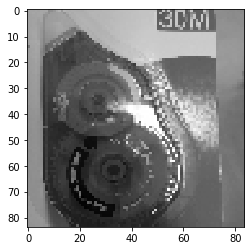

In [ ]:
IMG_SIZE = 84

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize the image into 84 x 84
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [ ]:
def create_Dataset():
    Dataset = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)  # create path to Correction Tape, Eraser and the rest
        class_num = CATEGORIES.index(category) # create label to Correction Tape, Eraser and the rest
        
        for img in tqdm(os.listdir(path)):  # iterate over each image per Correction Tape, Eraser and the rest
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resize to normalise data size
                Dataset.append([new_array, class_num]) # Add this two to our Dataset
            except Exception as e:
                pass
    return Dataset

In [ ]:
Dataset = create_Dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.81it/s]


In [ ]:
print(len(Dataset))

6000


In [ ]:
type(Dataset)

list

In [ ]:
X = []
y = []

In [ ]:
for features, label in Dataset:
    X.append(features)  # Add features to X
    y.append(label)   # Add label to y

import random
from random import shuffle
a = list(zip(X, y))
random.shuffle(a)

X, y = zip(*a)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_valid = X_train_full[-5000:], X_train_full[:-5000]
y_train, y_valid = y_train_full[-5000:], y_train_full[:-5000]

print(len(X_train))
print(len(y_train))
print(len(X))
print(len(y))

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

print(len(X_train))
print(len(y_train))
print(len(X))
print(len(y))

5000
5000
6000
6000
5000
5000
6000
6000


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D 
from functools import partial
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

DefaultConv2D = partial(keras.layers.Conv2D, 
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[IMG_SIZE, IMG_SIZE, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, validation_data=[X_valid, y_valid])

model.save("my_model.h5")

Train on 5000 samples, validate on 400 samples
Epoch 1/20
5000/5000 [==============================] - ETA: 5:07 - loss: 5.7124 - accuracy: 0.09 - ETA: 4:45 - loss: 5.6967 - accuracy: 0.09 - ETA: 4:33 - loss: 5.5432 - accuracy: 0.09 - ETA: 4:25 - loss: 5.4063 - accuracy: 0.08 - ETA: 4:19 - loss: 5.2798 - accuracy: 0.07 - ETA: 4:14 - loss: 5.1663 - accuracy: 0.06 - ETA: 4:10 - loss: 5.0605 - accuracy: 0.05 - ETA: 4:08 - loss: 4.9599 - accuracy: 0.06 - ETA: 4:05 - loss: 4.8734 - accuracy: 0.06 - ETA: 4:04 - loss: 4.7880 - accuracy: 0.07 - ETA: 4:04 - loss: 4.7109 - accuracy: 0.07 - ETA: 4:03 - loss: 4.6415 - accuracy: 0.07 - ETA: 4:04 - loss: 4.5766 - accuracy: 0.06 - ETA: 4:03 - loss: 4.5148 - accuracy: 0.07 - ETA: 4:03 - loss: 4.4578 - accuracy: 0.07 - ETA: 4:03 - loss: 4.4044 - accuracy: 0.08 - ETA: 4:03 - loss: 4.3551 - accuracy: 0.08 - ETA: 4:03 - loss: 4.3091 - accuracy: 0.08 - ETA: 4:02 - loss: 4.2660 - accuracy: 0.08 - ETA: 4:00 - loss: 4.2256 - accuracy: 0.08 - ETA: 3:59 - loss:

5000/5000 [==============================] - ETA: 4:21 - loss: 1.6895 - accuracy: 0.43 - ETA: 4:25 - loss: 1.9010 - accuracy: 0.35 - ETA: 4:25 - loss: 1.9445 - accuracy: 0.35 - ETA: 4:26 - loss: 1.9283 - accuracy: 0.36 - ETA: 4:25 - loss: 1.9441 - accuracy: 0.37 - ETA: 4:25 - loss: 1.9373 - accuracy: 0.36 - ETA: 4:23 - loss: 1.9364 - accuracy: 0.37 - ETA: 4:21 - loss: 1.9109 - accuracy: 0.39 - ETA: 4:20 - loss: 1.8991 - accuracy: 0.38 - ETA: 4:18 - loss: 1.9112 - accuracy: 0.36 - ETA: 4:16 - loss: 1.8998 - accuracy: 0.36 - ETA: 4:15 - loss: 1.8917 - accuracy: 0.38 - ETA: 4:13 - loss: 1.8950 - accuracy: 0.38 - ETA: 4:11 - loss: 1.8900 - accuracy: 0.38 - ETA: 4:10 - loss: 1.8758 - accuracy: 0.39 - ETA: 4:08 - loss: 1.8677 - accuracy: 0.39 - ETA: 4:06 - loss: 1.8597 - accuracy: 0.39 - ETA: 4:04 - loss: 1.8664 - accuracy: 0.39 - ETA: 4:02 - loss: 1.8703 - accuracy: 0.40 - ETA: 4:01 - loss: 1.8727 - accuracy: 0.40 - ETA: 3:59 - loss: 1.8831 - accuracy: 0.40 - ETA: 3:57 - loss: 1.8772 - accu

5000/5000 [==============================] - ETA: 4:54 - loss: 1.4806 - accuracy: 0.59 - ETA: 4:53 - loss: 1.6257 - accuracy: 0.53 - ETA: 4:51 - loss: 1.5953 - accuracy: 0.52 - ETA: 4:55 - loss: 1.6792 - accuracy: 0.48 - ETA: 5:08 - loss: 1.6975 - accuracy: 0.47 - ETA: 5:16 - loss: 1.6566 - accuracy: 0.49 - ETA: 5:20 - loss: 1.6450 - accuracy: 0.48 - ETA: 5:14 - loss: 1.6495 - accuracy: 0.48 - ETA: 5:16 - loss: 1.6737 - accuracy: 0.48 - ETA: 5:18 - loss: 1.6636 - accuracy: 0.48 - ETA: 5:11 - loss: 1.6482 - accuracy: 0.49 - ETA: 5:06 - loss: 1.6293 - accuracy: 0.51 - ETA: 5:04 - loss: 1.6346 - accuracy: 0.50 - ETA: 5:00 - loss: 1.6302 - accuracy: 0.51 - ETA: 4:56 - loss: 1.6557 - accuracy: 0.51 - ETA: 4:52 - loss: 1.6463 - accuracy: 0.50 - ETA: 4:49 - loss: 1.6648 - accuracy: 0.50 - ETA: 4:45 - loss: 1.6547 - accuracy: 0.51 - ETA: 4:42 - loss: 1.6332 - accuracy: 0.52 - ETA: 4:38 - loss: 1.6325 - accuracy: 0.52 - ETA: 4:35 - loss: 1.6235 - accuracy: 0.52 - ETA: 4:32 - loss: 1.6218 - accu

5000/5000 [==============================] - ETA: 4:43 - loss: 1.2868 - accuracy: 0.65 - ETA: 4:39 - loss: 1.2566 - accuracy: 0.68 - ETA: 4:37 - loss: 1.2800 - accuracy: 0.65 - ETA: 4:34 - loss: 1.2592 - accuracy: 0.67 - ETA: 4:34 - loss: 1.3365 - accuracy: 0.63 - ETA: 4:31 - loss: 1.3204 - accuracy: 0.63 - ETA: 4:30 - loss: 1.3217 - accuracy: 0.63 - ETA: 4:27 - loss: 1.3217 - accuracy: 0.64 - ETA: 4:24 - loss: 1.3407 - accuracy: 0.63 - ETA: 4:22 - loss: 1.3579 - accuracy: 0.62 - ETA: 4:20 - loss: 1.3379 - accuracy: 0.64 - ETA: 4:18 - loss: 1.3256 - accuracy: 0.63 - ETA: 4:18 - loss: 1.3273 - accuracy: 0.64 - ETA: 4:16 - loss: 1.3448 - accuracy: 0.63 - ETA: 4:16 - loss: 1.3423 - accuracy: 0.63 - ETA: 4:14 - loss: 1.3366 - accuracy: 0.63 - ETA: 4:13 - loss: 1.3244 - accuracy: 0.63 - ETA: 4:12 - loss: 1.3289 - accuracy: 0.63 - ETA: 4:12 - loss: 1.3260 - accuracy: 0.62 - ETA: 4:11 - loss: 1.3136 - accuracy: 0.63 - ETA: 4:11 - loss: 1.3111 - accuracy: 0.63 - ETA: 4:12 - loss: 1.3090 - accu

5000/5000 [==============================] - ETA: 4:25 - loss: 1.2348 - accuracy: 0.62 - ETA: 4:30 - loss: 1.3905 - accuracy: 0.54 - ETA: 4:29 - loss: 1.2649 - accuracy: 0.61 - ETA: 4:29 - loss: 1.3004 - accuracy: 0.60 - ETA: 4:28 - loss: 1.2644 - accuracy: 0.62 - ETA: 4:26 - loss: 1.2455 - accuracy: 0.62 - ETA: 4:25 - loss: 1.2195 - accuracy: 0.62 - ETA: 4:23 - loss: 1.2354 - accuracy: 0.62 - ETA: 4:22 - loss: 1.2449 - accuracy: 0.63 - ETA: 4:21 - loss: 1.2235 - accuracy: 0.65 - ETA: 4:19 - loss: 1.2145 - accuracy: 0.65 - ETA: 4:17 - loss: 1.2135 - accuracy: 0.66 - ETA: 4:15 - loss: 1.2042 - accuracy: 0.66 - ETA: 4:13 - loss: 1.2006 - accuracy: 0.66 - ETA: 4:12 - loss: 1.1913 - accuracy: 0.67 - ETA: 4:10 - loss: 1.1939 - accuracy: 0.68 - ETA: 4:10 - loss: 1.2011 - accuracy: 0.68 - ETA: 4:08 - loss: 1.1906 - accuracy: 0.68 - ETA: 4:06 - loss: 1.2100 - accuracy: 0.67 - ETA: 4:05 - loss: 1.2064 - accuracy: 0.68 - ETA: 4:03 - loss: 1.1982 - accuracy: 0.68 - ETA: 4:01 - loss: 1.1925 - accu

5000/5000 [==============================] - ETA: 4:22 - loss: 0.9108 - accuracy: 0.75 - ETA: 4:27 - loss: 1.0042 - accuracy: 0.75 - ETA: 4:27 - loss: 0.9550 - accuracy: 0.78 - ETA: 4:27 - loss: 1.0153 - accuracy: 0.76 - ETA: 4:25 - loss: 1.0183 - accuracy: 0.76 - ETA: 4:24 - loss: 1.0127 - accuracy: 0.77 - ETA: 4:22 - loss: 1.0712 - accuracy: 0.76 - ETA: 4:21 - loss: 1.0360 - accuracy: 0.77 - ETA: 4:19 - loss: 1.0435 - accuracy: 0.76 - ETA: 4:17 - loss: 1.0625 - accuracy: 0.76 - ETA: 4:16 - loss: 1.0901 - accuracy: 0.75 - ETA: 4:15 - loss: 1.0594 - accuracy: 0.76 - ETA: 4:14 - loss: 1.0504 - accuracy: 0.76 - ETA: 4:13 - loss: 1.0449 - accuracy: 0.76 - ETA: 4:12 - loss: 1.0706 - accuracy: 0.75 - ETA: 4:10 - loss: 1.0524 - accuracy: 0.76 - ETA: 4:08 - loss: 1.0530 - accuracy: 0.76 - ETA: 4:06 - loss: 1.0530 - accuracy: 0.76 - ETA: 4:04 - loss: 1.0644 - accuracy: 0.76 - ETA: 4:02 - loss: 1.0612 - accuracy: 0.76 - ETA: 4:00 - loss: 1.0668 - accuracy: 0.76 - ETA: 3:58 - loss: 1.0585 - accu

5000/5000 [==============================] - ETA: 4:39 - loss: 0.8910 - accuracy: 0.90 - ETA: 4:43 - loss: 0.9798 - accuracy: 0.82 - ETA: 4:50 - loss: 1.0390 - accuracy: 0.84 - ETA: 4:50 - loss: 1.0432 - accuracy: 0.83 - ETA: 4:53 - loss: 1.0350 - accuracy: 0.81 - ETA: 4:51 - loss: 1.0110 - accuracy: 0.82 - ETA: 4:51 - loss: 1.0071 - accuracy: 0.82 - ETA: 4:51 - loss: 1.0186 - accuracy: 0.82 - ETA: 4:51 - loss: 1.0176 - accuracy: 0.81 - ETA: 5:05 - loss: 1.0117 - accuracy: 0.81 - ETA: 5:09 - loss: 1.0279 - accuracy: 0.79 - ETA: 5:09 - loss: 1.0524 - accuracy: 0.78 - ETA: 5:09 - loss: 1.0571 - accuracy: 0.79 - ETA: 5:07 - loss: 1.0774 - accuracy: 0.78 - ETA: 5:03 - loss: 1.0762 - accuracy: 0.78 - ETA: 4:58 - loss: 1.0656 - accuracy: 0.79 - ETA: 4:54 - loss: 1.0663 - accuracy: 0.78 - ETA: 4:51 - loss: 1.0764 - accuracy: 0.78 - ETA: 4:53 - loss: 1.0639 - accuracy: 0.78 - ETA: 4:49 - loss: 1.0592 - accuracy: 0.78 - ETA: 4:45 - loss: 1.0633 - accuracy: 0.78 - ETA: 4:41 - loss: 1.0526 - accu

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

600/600 [==============================] - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s 19ms/step


In [ ]:
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Test loss:  0.9078928279876709
Test accuracy:  0.8316666483879089


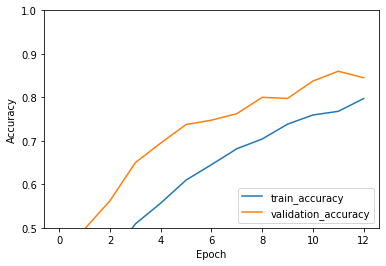

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

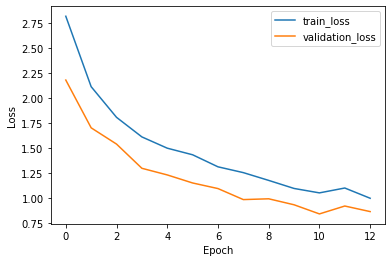

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

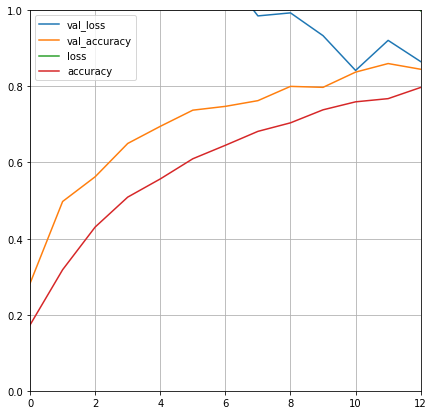

In [ ]:
import pandas as pd 

pd.DataFrame(history.history).plot(figsize=(7,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
predictions = model.predict_classes(X_test)

(10.0, 0.0)

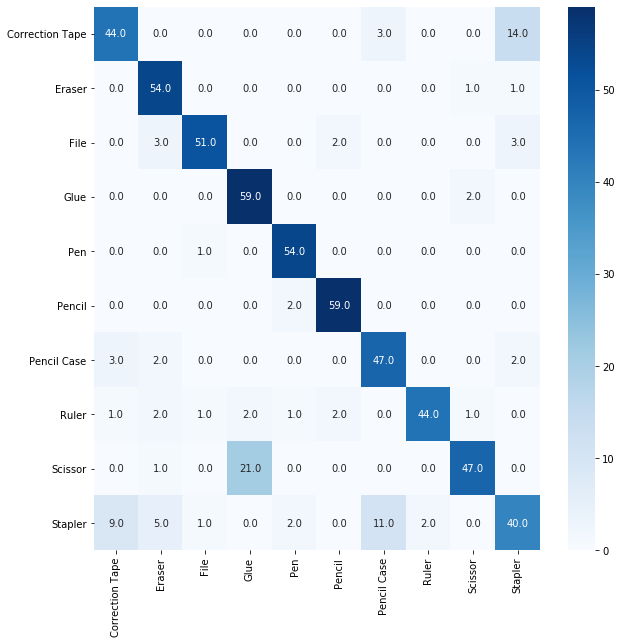

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm,annot=True,cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES, fmt=".1f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        61
           1       0.81      0.96      0.88        56
           2       0.94      0.86      0.90        59
           3       0.72      0.97      0.83        61
           4       0.92      0.98      0.95        55
           5       0.94      0.97      0.95        61
           6       0.77      0.87      0.82        54
           7       0.96      0.81      0.88        54
           8       0.92      0.68      0.78        69
           9       0.67      0.57      0.62        70

    accuracy                           0.83       600
   macro avg       0.84      0.84      0.83       600
weighted avg       0.84      0.83      0.83       600

